In [2]:
pickle_rel_path = '../datasets/notmnist/notMNIST.pickle'
import os
import pickle
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.python.framework import ops

### Import data

In [3]:
file_dir = os.path.dirname(os.path.realpath('__file__'))
pickle_path = os.path.abspath(os.path.join(file_dir, pickle_rel_path))
print('Pickle location:',pickle_path)

Pickle location: C:\Users\lgess\Documents\repo\learning_ai\datasets\notmnist\notMNIST.pickle


In [4]:
with open(pickle_path,'rb') as file:
    datasets = pickle.load(file)
print(datasets.keys())

dict_keys(['test_labels', 'valid_labels', 'valid_dataset', 'train_dataset', 'train_labels', 'test_dataset'])


In [5]:
train_dataset = datasets['train_dataset']
orig_train_labels = datasets['train_labels'] 
validate_dataset = datasets['valid_dataset']
orig_validate_labels = datasets['valid_labels'] 
test_dataset = datasets['test_dataset']
orig_test_labels = datasets['test_labels'] 

### Setup data

In [6]:
def setup_labels(label_array, num_labels):
    return ((np.arange(num_labels) == label_array[:,None]).astype(np.float32))

num_labels = 10
train_labels = setup_labels(orig_train_labels, num_labels)
validate_labels = setup_labels(orig_validate_labels, num_labels)
test_labels = setup_labels(orig_test_labels, num_labels)

### Normalize data

Pre-normalized

### Define model

In [7]:
ops.reset_default_graph()

batch_size = 128
iterations = 1000
layer1_size = 1024
layer2_size = num_labels
learning_rate = tf.placeholder_with_default(0.5, [])

samples_shape = np.append(None,train_dataset.shape[1:])
targets_shape = np.append(None,train_labels.shape[1:])
w1_shape = np.append(layer1_size,samples_shape[1:])
b1_shape = [layer1_size]
w2_shape = [layer2_size,layer1_size]
b2_shape = [layer2_size]
print(samples_shape,targets_shape)

samples = tf.placeholder(tf.float32, shape=samples_shape)
targets = tf.placeholder(tf.float32, shape=targets_shape)
initializer = tf.glorot_normal_initializer()
w1 = tf.get_variable("W1", shape=w1_shape, dtype=tf.float32, initializer=initializer)
b1 = tf.get_variable("B1", shape=b1_shape, dtype=tf.float32, initializer=initializer)
w2 = tf.get_variable("W2", shape=w2_shape, dtype=tf.float32, initializer=initializer)
b2 = tf.get_variable("B2", shape=b2_shape, dtype=tf.float32, initializer=initializer)

def weighted_inputs(x, w, b, rank): 
    axis = np.arange(1,rank)
    return tf.tensordot(x,w,(axis,axis))+b

def sigmoid_activation(z):
    exp = tf.exp(z)
    return (tf.div(exp,tf.add(exp,1)))

def softmax_activation(z,rank):
    exp = tf.exp(z)
    sum_ = tf.reduce_sum(exp,np.arange(1,rank))
    return exp/tf.reshape(sum_,[-1,1])
    
def model():
    layer1 = sigmoid_activation(weighted_inputs(samples,w1,b1,len(w1_shape)))
    layer2 = softmax_activation(weighted_inputs(layer1,w2,b2,len(w2_shape)),len(b2_shape)+1)
    return layer2

def loss_function():
    #return tf.reduce_mean(tf.square(targets-model()))
    return tf.reduce_mean(-tf.multiply(targets,tf.log(model())))

def training_step(loss):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    return optimizer.minimize(loss)

[None 28 28] [None 10]


### Train model

In [10]:
init = tf.global_variables_initializer()
sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))
sess.run(init)

In [11]:
# Training loop
loss = loss_function()
step = training_step(loss)   
index = 0
for i in range(iterations):
    feed_dict={samples: train_dataset[index:index+batch_size], targets: train_labels[index:index+batch_size]}      
    sess.run(step, feed_dict)
    if i%(iterations/10) == 0:
        loss_value = sess.run(loss, feed_dict)
        print(loss_value)
    index = index + batch_size
    if index + batch_size >= len(train_dataset):
        index = 0
loss_value = sess.run(loss, feed_dict)
print(loss_value)

writer = tf.summary.FileWriter("/tf.log", sess.graph)

0.23575187
0.13901386
0.10218233
0.09405238
0.073318705
0.08272201
0.07594327
0.07024832
0.078910045
0.06290753
0.06972141


### Evaluate Model

In [9]:
def predict():
    return tf.cast(tf.equal(model(),tf.reduce_max(model(),1,keep_dims=True)),tf.float32)

def accuracy():
    comparison_matrix = tf.reduce_all(tf.equal(predict(),targets),1)
    return tf.reduce_mean(tf.cast(comparison_matrix,tf.float32))

num_train = 100000
acc_train = sess.run(accuracy(),feed_dict={samples: train_dataset[:num_train], targets: train_labels[:num_train]})
acc_valid = sess.run(accuracy(),feed_dict={samples: validate_dataset, targets: validate_labels})
print(acc_train, acc_valid)

0.81603 0.8126


### Test sample

Label: [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]


array([[0., 0., 0., 1., 0., 0., 0., 0., 0., 0.]], dtype=float32)

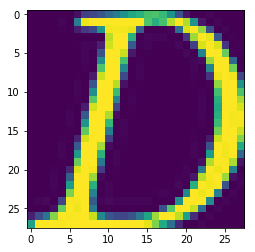

In [63]:
def show_sample(sample_image, label):
    plt.figure()
    plt.imshow(sample_image)
    print('Label:', label)

index=0
show_sample(validate_dataset[index],validate_labels[index])
sess.run(predict(),feed_dict={samples: [validate_dataset[index]]})